<a href="https://colab.research.google.com/github/mariaeduardagimenes/NLP/blob/master/NLP_An%C3%A1lise_Sentimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NLP - Análise de Sentimento**

Refere-se ao uso de Processamento de Linguagem Natural a fim de identificar, extrair e quantificar a polaridades expressas nos dados, em formato de texto, podendo ser aplicada também em áudio, vídeo, imagem.

A combinação de NLP e Machine Learning possibilita classificar o sentimento expresso em determinado texto: se é negativo, neutro, positivo, etc.


###**Tipos de Abordagem**

**Dicionários Léxicos:** o sentimento das palavras pode ser combinado para gerar uam classificação de uma sentença.
- Vantagens: Não há necessidade de dados de treino.
- Desvantagem: dependência do idioma e o custo de manutenção.


**Machine Learning:** normalmente consiste em modelar os dados de texto no formato BoW (saco de palavras).

- Vantagem: não dependência de idiomas.
- Desvantagem: necessidade de ter dados de treino.


**Deep Learning:** consegue aprender padrões de escrita ou contexto no qual o texto é inserido.
- Vantagem: exige menos trabalho de feature engineer (criar novas features)
- Desvantagem: necessita de um grande volume de dados para treino.




###**Etapas**

1. Limpeza e padronização dos textos nos documentos.
2. Extração de todas as palavras dos documentos com um BoW.
3. Produção de uma vetorização de texto do documento.
4. Treinamento de um algoritmo de ML para reconhecer textos positivos vs. negativos.
5. Avaliação do modelo criado em documentos de teste.

#**Coleta de dados** 

Todo problema de Machine Learning começa com dados. 

Pode ser uma lista de e-mails, posts em redes sociais, tweets, reviews em sites de compras, etc. Podemos coletar usando APIs, fazendo web scrapping, ou utilizar datasets disponíveis na internet.

A base de dados que iremos utilizar foi coletada do Twitter e contém termos referentes a educação e a política do Estado de Minas Gerais.

Os dados já estão rotulados, como positivo, negativo ou neutro. Caso não estivesse, precisariamos utilizar aprendizado não supervisionado para rotular. Porém, podemos utilizar esses dados e treinar um classificador.


In [ ]:
# Primeiramente importamos as bibliotecas que serão utilizadas em nossa anáise:

import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import re
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
import toolz as fp
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# O pandas é uma biblioteca de análise de dados gratuita e de código aberto para Python.
# Ajuda a manipular uma grande quantidade de dados de forma muito rápida e eficiente 

# Vamos usar a função read_csv() do pandas para ler nossa base de dados



import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Tweets_Mg.csv')
df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#**Exploração dos dados**

É uma etapa importante para entendermos nossos dados e podermos tirar os melhores insights.

In [ ]:
# O atributo shape retorna uma tupla que consiste nas dimensões da Array, 
#mostrando quantas linha e colunas possui nosso dataset.


df.shape

(8199, 26)


Temos 8199 linhas e 26 *colunas*

In [ ]:
# Distribuição das classes da coluna ‘Classificação’:
df.Classificacao.value_counts()

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64

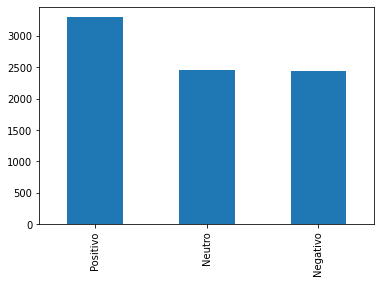

In [ ]:
 # Visualizando esses dados graficamente:
df.Classificacao.value_counts().plot(kind='bar')

As classes estão balanceadas.

#**Limpeza e Padronização**


Vamos deixar apenas as colunas que nos interessam.

In [ ]:
# Vamos usar a função .rename() para renomear as colunas que queremos, e .loc() para escolhermos quais funções vamos manter


np.random.seed(42)
df = (df
               .rename(columns={"Created At": "data_publicacao",
                                "Text": "tweet",                                
                                "Retweet Count" : "num_retweets",
                                "Username": "usuário",
                                "Classificacao": "sentimento"})
               .loc[:, ["data_publicacao", "tweet", "num_retweets",  "usuário", "sentimento"]])
df["data_publicacao"] = pd.to_datetime(df["data_publicacao"],infer_datetime_format=True)

In [ ]:
#Visualizar nosso novo dataframe, agora mais limpo.

df.head()

,data_publicacao,tweet,num_retweets,usuário,sentimento
0,2017-01-08 01:22:05+00:00,���⛪ @ Catedral de Santo Antônio - Governador ...,0,Leonardo C Schneider,Neutro
1,2017-01-08 01:49:01+00:00,"� @ Governador Valadares, Minas Gerais https:/...",0,Wândell,Neutro
2,2017-01-08 01:01:46+00:00,"�� @ Governador Valadares, Minas Gerais https:...",0,Wândell,Neutro
3,2017-01-04 21:43:51+00:00,��� https://t.co/BnDsO34qK0,0,Ana estudando,Neutro
4,2017-01-09 15:08:21+00:00,��� PSOL vai questionar aumento de vereadores ...,0,Emily,Negativo


##**Remover linhas duplicadas na base de dados**

No Twitter é muito comum que as pessoas republiquem conteúdos de outrem (retweet). Precisamos tratar isso pois provavelmente existem tweets duplicados em nossa base. 

In [ ]:
#Número de linhas da coluna 'tweet''

df.tweet.count()

8199

In [ ]:
# Removendo os valores duplicados:
df.drop_duplicates(['tweet'], inplace=True)

In [ ]:
#Verificando novamente
df.tweet.count()

5765

De fato nossa base tinha um grande número de valores duplicados. 
É importante remover a duplicidade, pois, dependendo da análise, isso pode alterar o resultado final.

Como vamos analisar apenas as colunas tweet e sentimento, vamos criar colunas para armazenas esses dados.

##**Separando tweets e suas classes**




In [ ]:

tweets = df['tweet']
classes = df['sentimento']

In [ ]:
# Overview

df.groupby("sentimento").count()

,data_publicacao,tweet,num_retweets,usuário,tokens
sentimento,,,,,
Negativo,951,951,951,951,951
Neutro,1974,1974,1974,1974,1974
Positivo,2840,2840,2840,2840,2840


##**Verificar as palavras mais frequentes**


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


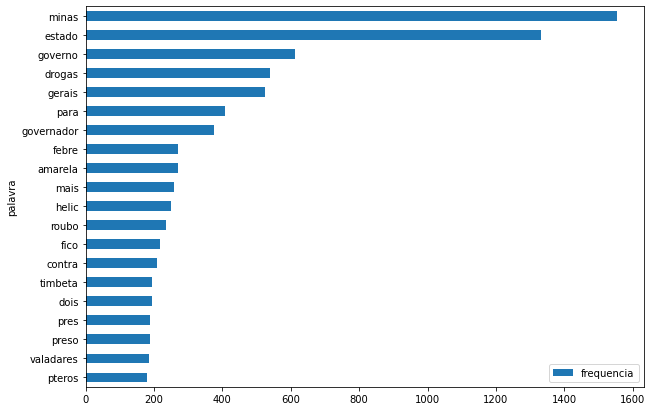

In [ ]:
# Com a biblioteca nltk (própria para NLP) podemos verificar as palavras
# mais frequentes dos tweets. 

# Vamos olhar as 20 palavras mais frequentes, que tem mais de 3 caractéres (evitamos algumas stopwords)

# Aqui já utilizamos tokenização, mas falarei disso mais para frente, na parte de pré-processamento
# Nesse momento é só para visualizar as palavras mais comuns
import nltk
nltk.download('punkt')

tweet_words = nltk.tokenize.word_tokenize(df["tweet"].drop_duplicates().str.lower().str.cat(sep=" ")) # separa em palavras
word_dist = fp.pipe(fp.keyfilter(lambda x: len(x) > 3, nltk.FreqDist(tweet_words)), # apenas palavras com mais de 3 caracteres
                    nltk.probability.FreqDist)

fig, ax = plt.subplots(figsize=(10, 7))

(pd.DataFrame(word_dist.most_common(20)[::-1],
              columns=['palavra', 'frequencia'])
    .plot.barh(x="palavra", y="frequencia", ax=ax));

Os computadores não interpretam letras e dígitos como nós humanos. Os comandos e dados processados pela máquina são transformados em sequencias de 0 e 1.

A biblioteca NLTK contém pacotes para fazer com que as máquinas entendam a linguagem humana.

##**Stopwords**

**Palavras e termos que não tem relevância para um texto.**


In [ ]:
# Remover Stopwords

# Stopwords são palavras que não tem relevância para o sentido do texto, ex: uma, um, com, de, que, etc

# nltk possui uma lista de stopwords em 16 idiomas diferentes, e nós vamos criar a função RemoveStopWords() para remover as stopwords em português

def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

#**Stemming**



**Reduzir uma palavra para o seu radical. Remove os sufixos.** 

Ex: gato e gatinho tem o mesmo sentido para um texto, então deixamos na desinência 'gat'para termos melhor noção do texto


In [ ]:
# Stemming


def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))



##**Remover caracteres indesejados, como links, rtc**

In [ ]:
# Remover caracteres indesejados, como links, etc

def Limpeza_dados(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

##**Lemmatization** 

**Reduz as palavras flexionadas adequadamente e determinando a palavra que representa seu lema.**

Construções e construir são formas da palavra execução. Execução é o lema dessas palavras

Esse processo só está disponível em inglês, mas utiliza a função WordNetLemmatizer() do pacote nltk

#**Criar e aplicar a função Preprocessing()**




Reunir todas as etapas citadas previamente.

In [ ]:

def Preprocessing(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','').replace('"','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [ ]:
tweets = [Preprocessing(i) for i in tweets]

In [ ]:
# Vamos visualizar um pouco nossos textos
tweets[:10]

['catedral santo ant nio governador valadares mg',
 'governador valadares, minas gerais',
 'governador valadares, minas gerais',
 '',
 'psol vai questionar aumento vereadores prefeito bh justi politica estado minas',
 'bom bandido morto deputado cabo j lio condenado fica ineleg vel 10 anos politica estado minas',
 '25 mineiros dizem n torcer time nenhum,mesmo dentro estado atl tico mg cruzeiro pq?',
 'gigantesca barba mal destaque caderno cultura estado minas',
 'bb governo minas travam disputa sobre dep sitos judiciais',
 'vcs bh fica pequena! belo horizonte (pron b lo i z nt i 10 capital estado mg, rea aproximadamente 331 km']

Conseguimos enxergar nossos tweets mais organizados e limpos.

##**Vamos visualizar nossa nuvem de palavras**

Uma outra maneira de visualizarmos as palavras-chave do texto.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


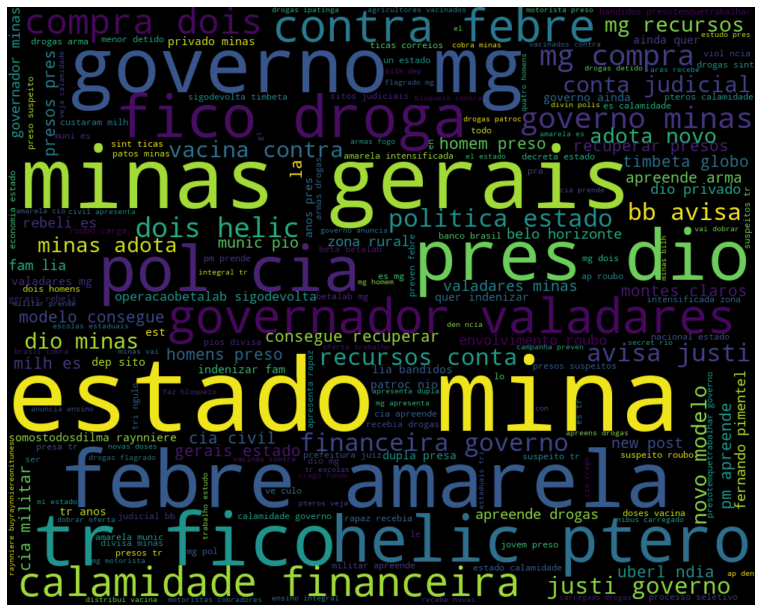

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
nltk

stopwordsPOR = nltk.corpus.stopwords.words('portuguese')

stopwordsPOR

words1 = []
for i in df.tweet:
    for p in i.lower().split():
        if p not in stopwordsPOR and p not in tweets:
         
            words1.append(p)
            
#convert list to string and generate
unique_string=(" ").join(words1)

wordcloud = WordCloud(width=1000, height=800, margin=0).generate(unique_string)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.margins(x=0, y=0)



##**Criar a coluna de tokens**

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["tweet"].apply(tokenizer.tokenize)
df.head()

,data_publicacao,tweet,num_retweets,usuário,sentimento,tokens
0,2017-01-08 01:22:05+00:00,em catedral de santo ant nio governador...,0,Leonardo C Schneider,Neutro,"[em, catedral, de, santo, ant, nio, governador..."
1,2017-01-08 01:49:01+00:00,"em governador valadares, minas gerais",0,Wândell,Neutro,"[em, governador, valadares, minas, gerais]"
2,2017-01-08 01:01:46+00:00,"em governador valadares, minas gerais",0,Wândell,Neutro,"[em, governador, valadares, minas, gerais]"
3,2017-01-04 21:43:51+00:00,,0,Ana estudando,Neutro,[]
4,2017-01-09 15:08:21+00:00,psol vai questionar aumento de vereadores ...,0,Emily,Negativo,"[psol, vai, questionar, aumento, de, vereadore..."


In [ ]:
#Visualizar o número e tamanho dos tweets

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s palavras no total, com um vocabulário de tamanho %s" % (len(all_words), len(VOCAB)))
print("O comprimento máximo de frase é %s" % max(sentence_lengths))





84886 palavras no total, com um vocabulário de tamanho 6136
O comprimento máximo de frase é 35


In [ ]:
tokens = df["tokens"]



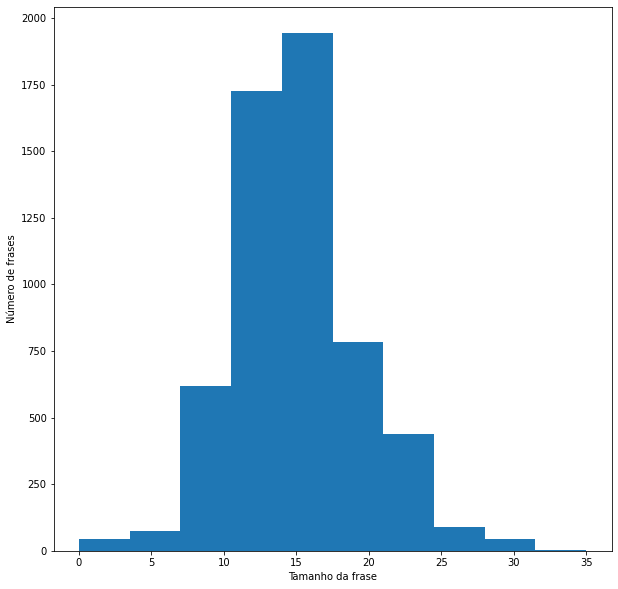

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da frase')
plt.ylabel('Número de frases')
plt.hist(sentence_lengths)
plt.show()

#**Criando o modelo**

**Para classificar os tweets em positivo, negativo ou neutro.**

1. Vamos criar o modelo para classificar os tweets em positivo, negativo ou neutro

2. Vamos criar o código que treina o modelo usando a abordagem Bag of Words e o algoritmo Naive Bayes Multinomial 

3. Vamos utilizar o # CountVectorizer() #  que fornece uma maneira simples de tokenizar uma coleção de documentos de texto e criar um vocabulário de palavras conhecidas. 

4. E também codificar novos documentos usando esse vocabulário. É retornado u mvetor codificado com um comprimento de todo o vocabulário e uma contagem inteira para o número de vezes que cada palavra apareceu no documento

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

###**Instancia o objeto que faz a vetorização dos dados de texto**

In [ ]:
vectorizer = CountVectorizer(analyzer="word")

Usamos vectorizer para calcular a frequência de todas as palavras da lista de tweets e armazenamos seu retorno em freq_tweets

In [ ]:

freq_tweets = vectorizer.fit_transform(tweets)
type(freq_tweets)

scipy.sparse.csr.csr_matrix

Retorna uma matriz esparsa, com vários zeros

In [ ]:
# Visualizando o número de linhas e colunas da matriz:
freq_tweets.shape



(5765, 6023)

Cada palavra da nossa base se tornou uma coluna

#**Escolha do Algoritmo**

**Naive-Bayes**

Vamos utilizar o algoritmo Naive Bayes, classificador probabilístico muito usado em ML,  para categorizar textos com base na frequência das palavras usadas.

Treino de modelo de Machine Learning usando a frequência de palavras (freq_tweets), e as classes de cada instância.


In [ ]:
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Com o modelo criado, vamos testá-lo com algumas instâncias simples

Defina instâncias de teste dentro de uma lista:

In [ ]:
testes = ['Esse governo está no início, vamos ver o que vai dar',
          'Estou muito feliz com o governo de Minas esse ano',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'A segurança desse país está deixando a desejar',
          'O governador de Minas é mais uma vez do PT']

**Bag of Words**

O modelo baseado em Bag of words utiliza todas as palavras do texto, a frequência de cada palavra e associa isso a classe do treino. A frequência das palavras é usada para treinar um modelo. 

Vamos transformá-las no formado bag of words e passar para nosso modelo classificar  


In [ ]:
# vectorizer.transform() transforma os dados de teste em vetores de palavras:
freq_testes = vectorizer.transform(testes)

In [ ]:
modelo.predict(freq_testes)

array(['Neutro', 'Neutro', 'Negativo', 'Negativo', 'Neutro'], dtype='<U8')

Nosso modelo errou na segunda instância, onde a classe deveria ser Positivo

Fazendo a classificação com o modelo treinado

In [ ]:
for t, c in zip (testes,modelo.predict(freq_testes)):
    # t representa o tweet e c a classificação de cada tweet.
    print (t +", "+ c) 
    
# No final de cada frase, vemos a classificação do tweet

Esse governo está no início, vamos ver o que vai dar, Neutro
Estou muito feliz com o governo de Minas esse ano, Neutro
O estado de Minas Gerais decretou calamidade financeira!!!, Negativo
A segurança desse país está deixando a desejar, Negativo
O governador de Minas é mais uma vez do PT, Neutro


Probabilidade de cada classe. 

Cada linha é uma frase de testes e as colunas relacionam as frases com o sentimento


In [ ]:
print(modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.21, 0.79, 0.  ],
       [0.13, 0.81, 0.06],
       [1.  , 0.  , 0.  ],
       [0.58, 0.32, 0.09],
       [0.2 , 0.79, 0.  ]])

#**Modelos com Pipelines**
Podemos também criar modelos com pipelines, para reduzir o código e automatizar fluxos.

Teriamos que importar Pipeline da biblioteca scikit learn 



In [ ]:
# Vetorizando os dados e passando o classificador:

from sklearn.pipeline import Pipeline
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])
pipeline_simples.fit(tweets,classes)



Pipeline(memory=None,
         steps=[('counts',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

#**Avaliando o modelo**

Até agora só testamos para ver como funciona na prática.

Precisamos, entretanto, avaliar o modelo com dados que o modelo não conhece para termos uma noção de como vai se sair em um sistema real.

Podemos separar parte dos dados para treino e parte para teste. Porém, se tivermos os dados de treinamento muito parecidos com o de teste, teríamos um ótimo resultado mas que nao refletisse necessariamente a realidade na qual o modelo será usado

#**Cross Validation**
É uma forma melhor de validar o modelo criado.

Essa técnica consiste em dividir todo o dado em K partes, que serão chamadas de folds. Dessas partes, uma será separada para teste e as outras usadas para treinar o modelo. 

Isso é feito repetidamente até que o modelo seja treinado e testado com todas as partes.

In [ ]:
# Para implementar a validação do modelo, vamos usar a função cross_val_predict()

resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

In [ ]:
#A primeira métrica que vamos medir é a Acurácia do 
#modelo - o percentual de acertos que o modelo teve


metrics.accuracy_score(classes,resultados)

#o modelo acertou 84% dos testes

0.8634865568083261

In [ ]:
# Medidas de validação do modelo:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))



              precision    recall  f1-score   support

    Positivo       0.97      0.87      0.91      2840
    Negativo       0.73      0.90      0.81       951
      Neutro       0.81      0.84      0.82      1974

    accuracy                           0.86      5765
   macro avg       0.84      0.87      0.85      5765
weighted avg       0.87      0.86      0.87      5765



As métricas estão muito boas.

#**Outras métricas de classificação: precision, recall, f1-score**

1. Precision (precisão) precision = true positive / (true positive + false positive)
Significa o número de vezes que uma classe foi predita corretamente dividida pelo número de vezes que a classe foi predita.

2. Recall (revocação) recall = true positive / (true positive + false negative)
Isso significa o número de vezes que uma classe foi predita corretamente (TP) dividido pelo número de vezes que a classe aparece no dado de teste (FN).

3. F1-score
f1-score = 2*((precision * recall) / (precision + recall)
Essa medida é a média harmônica entre precisão e revocação. Com essa informação, podemos dizer a performance do classificador com um indicador apenas.

Como essa medida é uma média, ela dá uma visão mais exata da eficiência do classificador do que apenas a precisão ou a revocação.

**Matriz de confusão**

In [ ]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       856      91         4   951
Neutro         234    1663        77  1974
Positivo        75     306      2459  2840
All           1165    2060      2540  5765


In [ ]:
# Função para automatizar todo o processo acima:
def Metricas(modelo, tweets, classes):
  resultados = cross_val_predict(modelo, tweets, classes, cv=10)
  return 'Acurácia do modelo: {}'.format(metrics.accuracy_score(classes,resultados))

# Naive Bayes simples- acurácia do modelo:
Metricas(pipeline_simples,tweets,classes)

'Acurácia do modelo: 0.8685169124024285'

#**Melhorando o modelo com Bigrams**

 Essa modelagem consiste em passar duas palavras como features para o classificador ao invés de apenas uma. Dessa forma, estamos dizendo que uma palavra tem uma relação com outra palavra, veja um exemplo:

Na frase: “Eu não gosto desse governo”, na modelagem inicial, passamos para o modelo cada palavra sendo uma feature, ficaria = {eu, não, gosto, desse, governo}

Usando Bigrams, passaríamos para o modelo 2 palavras, veja:

{eu não, não gosto, gosto desse, desse governo}

**Bigrams**

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,2)) # #ngram_range(1,2) faz a modelagem
freq_tweets = vectorizer.fit_transform(tweets) 
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Cross Validation**

In [ ]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

**Medindo a acurácia do modelo**


In [ ]:
metrics.accuracy_score(classes,resultados)

0.8660884648742411

A acurácia não melhorou com bigrams.

#**Medidas de validação do modelo**

In [ ]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.98      0.87      0.92      2840
    Negativo       0.68      0.93      0.78       951
      Neutro       0.85      0.83      0.84      1974

    accuracy                           0.87      5765
   macro avg       0.83      0.88      0.85      5765
weighted avg       0.88      0.87      0.87      5765



Apesar de a acurácia não ter melhorado, outras métricas melhoraram.

**Vamos olhar a matriz de confusão**

In [ ]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       898      52         1   951
Neutro         306    1614        54  1974
Positivo       168     181      2491  2840
All           1372    1847      2546  5765


**Apesar de a acurácia não ter melhorado, tivemos ganhos em outras métricas e na quantidade de verdadeiros negativos. E redução de falsos negativos, o que pode ser muito valioso.**